In [1]:
%matplotlib widget
import numpy as np
import pyroomacoustics as pra
import soundfile as sf
import os
import matplotlib.pyplot as plt
from wandas.core import ChannelFrame

/usr/local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


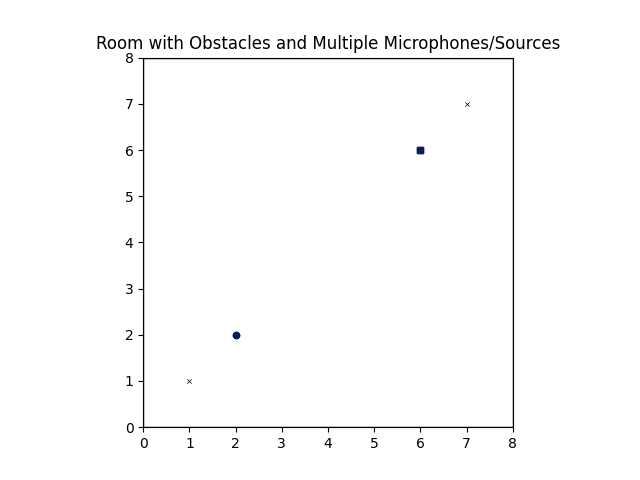

In [2]:
# 音声ファイル読み込み (例: LibriSpeech データセット)
data_dir = "./data"
fs = 32000
source_audio_files = [
    "target.wav", 
    "noise.wav", 
]
source_audio_files = [os.path.join(data_dir, f) for f in source_audio_files]
assert all(os.path.exists(f) for f in source_audio_files), "音声ファイルが見つかりません"
source_signals = [sf.read(file)[0][:fs*5] for file in source_audio_files]


# 部屋の形状を設定（角の座標）
corners = np.array([
    [0, 0], [8, 0], [8, 8], [0, 8]
]).T  # 転置して [2, N] の形に

# 壁の吸収率を設定
absorption = 0.4  # 一般壁の吸収率
scattering = 0.1  # 散乱率

# 部屋の作成
room = pra.Room.from_corners(
    corners=corners,
    fs=fs,
    materials=pra.Material(absorption, scattering),
    max_order=12  # 反射の最大回数
)

# マイクを配置
mic_positions = np.array([[1.0, 1.0], [7.0, 7.0]]).T  # 2つのマイクの座標
room.add_microphone_array(mic_positions)

# 音源を配置
# 音源配置と信号追加
source_positions = [[2.0, 2.0], [6.0, 6.0]]  # 2つの音源の座標
for position, signal in zip(source_positions, source_signals):
    room.add_source(position, signal=signal)


# 描画
fig, ax = room.plot()
ax.set_title("Room with Obstacles and Multiple Microphones/Sources")
plt.show()

# シミュレーション実行
room.simulate()


In [3]:
# マイク信号取得
mic_signals = room.mic_array.signals

# 各音源の残響込み信号を生成（RIRを畳み込み）
reverberant_signals = []
for i, src in enumerate(room.sources):
    rir = room.rir[0][i]  # マイク0と音源iのRIR
    reverberant_signal = np.convolve(source_signals[i], rir, mode='same')
    reverberant_signals.append(reverberant_signal)
reverberant_signals = np.array(reverberant_signals)
val_signal = ChannelFrame.from_ndarray(np.vstack((mic_signals[...,:reverberant_signals.shape[-1]], reverberant_signals)), sampling_rate=fs, labels=["mixed", "noise"]+["tgt", "noise_clean"])


In [4]:
val_signal.describe()

/usr/local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


In [5]:
import torch
import yaml
import numpy as np
from wandas.core import ChannelFrame
# 'model'ディレクトリをPythonのパスに追加
from system.sep_system import TwoChSepSystem
from models.dcunet import TwoChDCUNet

from torchmetrics.audio.snr import (
    signal_noise_ratio as snr,
)

import pytorch_lightning as pl
pl.seed_everything(114514)

torch.set_float32_matmul_precision("high")


/usr/local/lib/python3.10/site-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
Seed set to 114514


In [6]:
with open("./DCUNet/conf_finetuning.yml") as f:
    conf = yaml.safe_load(f)
conf["exp_dir"] = "../exp/DCUNet_TwoNoise_ClossTalk"

model = TwoChDCUNet(
    **conf["filterbank"],
    **conf["masknet"],
    sample_rate=conf["data"]["sample_rate"],
)

def loss_fn(pred, tgt):
    return - snr(pred, tgt).mean()

system = TwoChSepSystem(
        model=model,
        loss_func=loss_fn,
        optimizer=None,
        train_loader=None,
        val_loader=None,
        scheduler=None,
        config=conf,
    )

state_dict = torch.load("./exp/checkpoints/epoch=66-step=670000.ckpt", weights_only=True, map_location="cpu")
system.load_state_dict(state_dict=state_dict["state_dict"])
system.cpu()

TwoChSepSystem(
  (model): TwoChDCUNet(
    (encoder): Encoder(
      (filterbank): STFTFB()
    )
    (masker): TwoChDCUMaskNet(
      (encoders): ModuleList(
        (0): DCUNetComplexEncoderBlock(
          (conv): ComplexMultiplicationWrapper(
            (re_module): Conv2d(2, 32, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2), bias=False)
            (im_module): Conv2d(2, 32, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2), bias=False)
          )
          (norm): OnReIm(
            (re_module): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (im_module): BatchNorm(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (activation): OnReIm(
            (re_module): LeakyReLU(negative_slope=0.01)
            (im_module): LeakyReLU(negative_slope=0.01)
          )
        )
        (1): DCUNetComplexEncoderBlock(
          (conv): ComplexMultiplicationWrapper(
            (re_module): Conv2d(32, 32

In [7]:
mixed, noise = val_signal["mixed"].data, val_signal["noise"].data
tgt = val_signal["tgt"].data

In [8]:
est_targets = model(torch.stack([torch.from_numpy(mixed.astype(np.float32)), torch.from_numpy(noise.astype(np.float32))], dim=0).unsqueeze(0)).squeeze()
est_targets =est_targets.detach().numpy()
est_noise = (mixed - est_targets).squeeze()
sep_signal = ChannelFrame.from_ndarray(np.stack([mixed, noise, tgt, est_targets, val_signal["noise_clean"].data, est_noise], axis=0), sampling_rate=conf["data"]["sample_rate"], labels=["mixed", "noise", "tgt", "est_tgt", "noise_clean", "est_noise"])


In [9]:
for ch in sep_signal:
    print(f"{ch.label} snr:{snr(torch.from_numpy(ch.data), torch.from_numpy(tgt))}")
sep_signal.to_Audio()

mixed snr:-3.540931139779268
noise snr:-3.781332059344922
tgt snr:175.92230826873023
est_tgt snr:-2.171352409311214
noise_clean snr:-0.7105864876056398
est_noise snr:-1.0178619511200786


/usr/local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


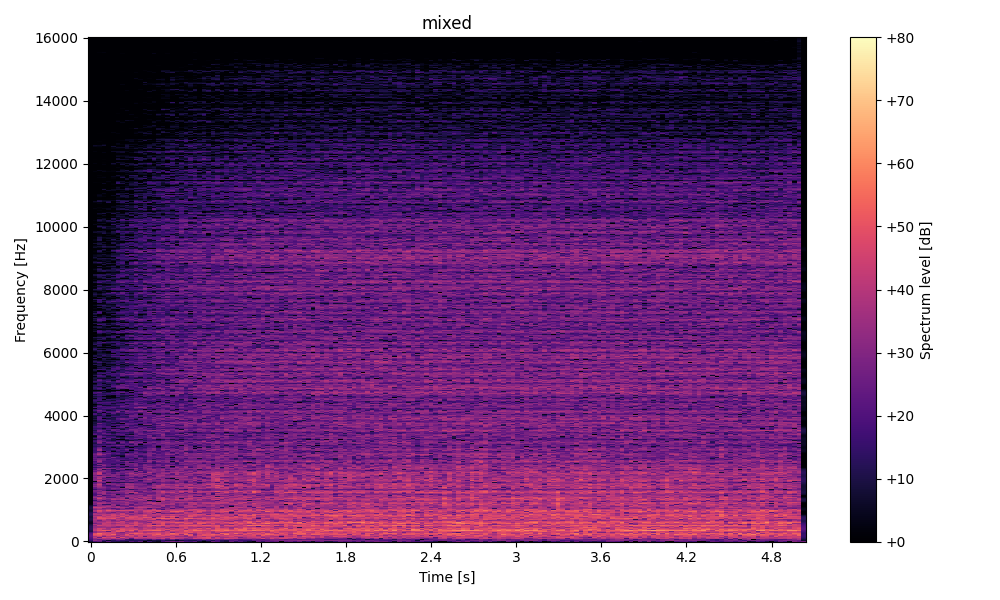

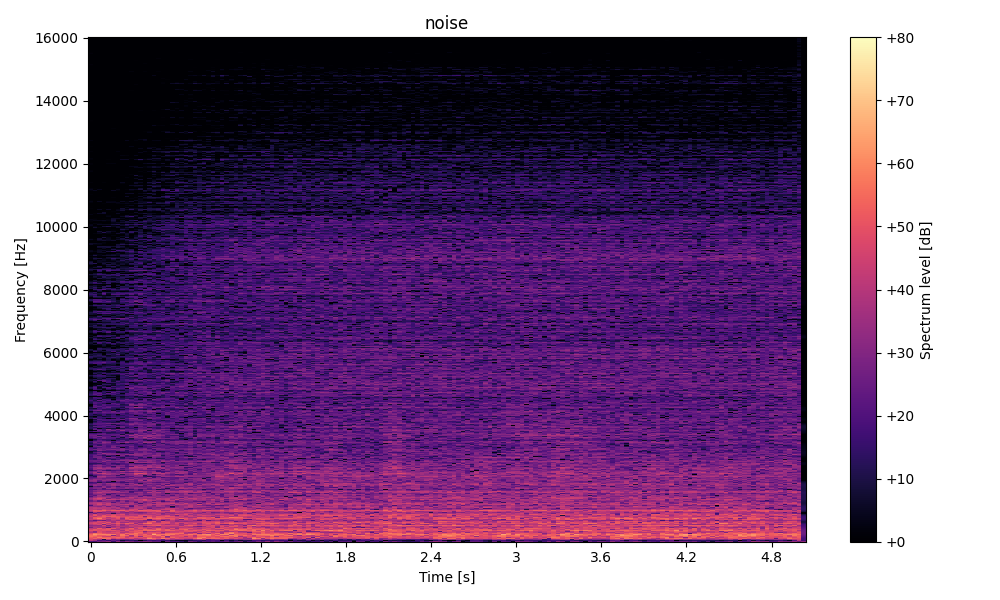

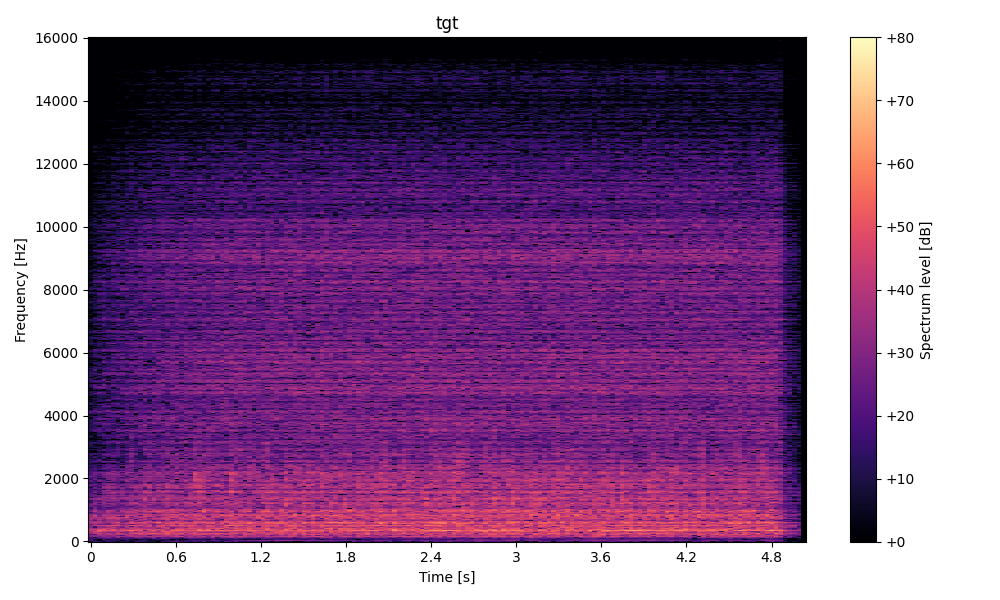

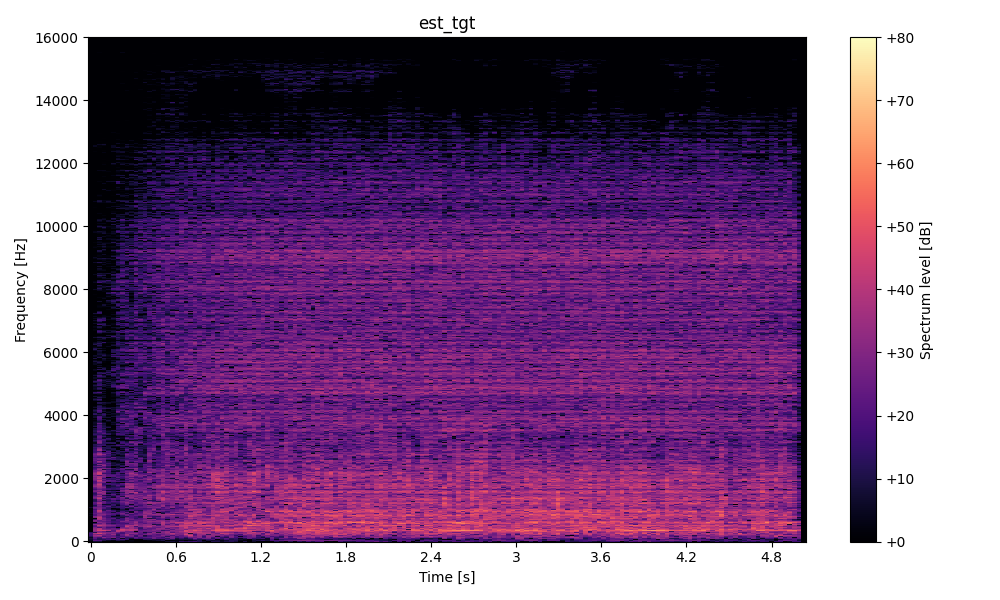

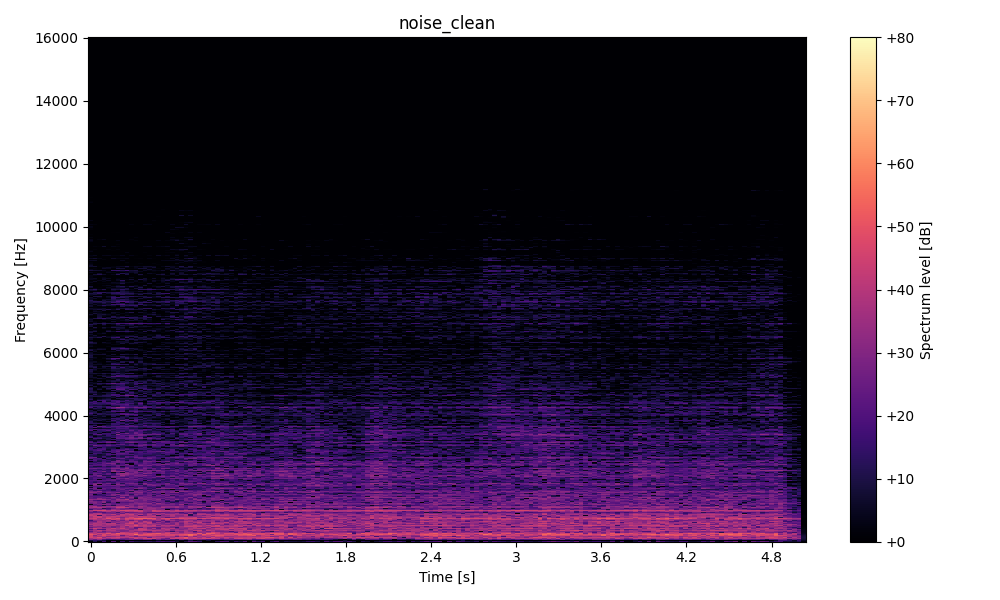

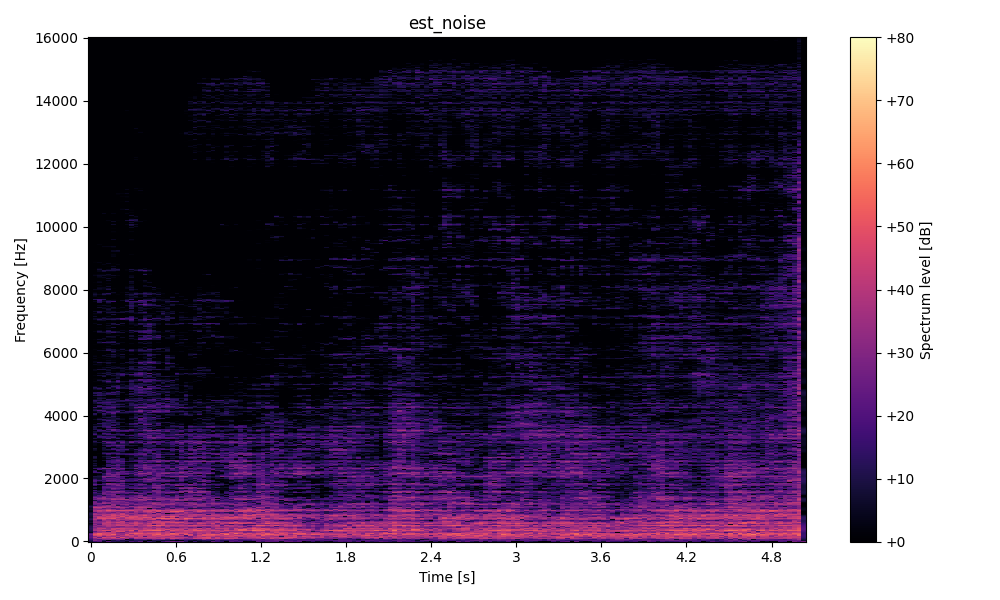

In [10]:
for ch in sep_signal:
    ch.stft().plot(vmin=0, vmax=80)